In [92]:
!pip install category_encoders==2.*

In [ ]:
import sys
!{sys.executable} -m pip install xgboost
# !{sys.executable} -m pip install pdpbox

In [173]:
conda install -c conda-forge pdpbox

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\iespi\anaconda3

  added / updated specs:
    - pdpbox


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.10.3               |   py38haa244fe_3         3.1 MB  conda-forge
    pdpbox-0.2.1               |     pyhd8ed1ab_0        22.2 MB  conda-forge
    python_abi-3.8             |           2_cp38           4 KB  conda-forge

Note: you may need to restart the kernel to use updated packages.


Did not find path entry C:\Users\iespi\anaconda3\bin


    ------------------------------------------------------------
                                           Total:        25.3 MB

The following NEW packages will be INSTALLED:

  pdpbox             conda-forge/noarch::pdpbox-0.2.1-pyhd8ed1ab_0
  python_abi         conda-forge/win-64::python_abi-3.8-2_cp38

The following packages will be UPDATED:

  conda              pkgs/main::conda-4.10.3-py38haa95532_0 --> conda-forge::conda-4.10.3-py38haa244fe_3




python_abi-3.8       | 4 KB      |            |   0% 
python_abi-3.8       | 4 KB      | ########## | 100% 
python_abi-3.8       | 4 KB      | ########## | 100% 

conda-4.10.3         | 3.1 MB    |            |   0% 
conda-4.10.3         | 3.1 MB    | 2          |   2% 
conda-4.10.3         | 3.1 MB    | 4          |   4% 
conda-4.10.3         | 3.1 MB    | 8          |   8% 
conda-4.10.3         | 3.1 MB    | #5         |  15% 
conda-4.10.3         | 3.1 MB    | ##1        |  21% 
conda-4.10.3         | 3.1 MB    | ##6        |  26% 


In [145]:
# importing toolkits
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve, roc_auc_score, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from category_encoders import OneHotEncoder, OrdinalEncoder
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor 
from sklearn.linear_model import Ridge, LinearRegression

Organizing like the Romans 

In [137]:
# filepath
data = 'marketing_campaign.csv'

# wrangle function
def wrangle(filepath):
  # reading in
  df = pd.read_csv(filepath,
                  sep='\t',
                  parse_dates=['Dt_Customer'],
                  index_col='Dt_Customer').sort_index()
  # dropped columns
  weights = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
            'AcceptedCmp2','Z_CostContact','Z_Revenue','ID', 'Response', 'Complain', 'Education']
  df.drop(columns=weights,inplace=True)
  # make marital status binary
  df['Marital_Status'] = df['Marital_Status'].map({'Single':0, 'Divorced':0,'Widow':0,'Alone':0,'YOLO':0, 'Absurd':0,'Together':1, 'Married':1})
  # before this next line income had about 1900 unique values now it 106
  df['Income']= round(df['Income'],-3)
  # drop nans
  df.dropna(inplace=True)
  # print out
  return df

# using the function
df  = wrangle(data)
# making the dataset binary
# threshold = income mean
# product binary = use threshold of mean of each purchase amount
# randomforestclass __ hypertuning in multiclass

df.head()

,Year_Birth,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
Dt_Customer,,,,,,,,,,,,,,,,,
2012-01-08,1985,1,8000.0,1,0,98,5,17,17,13,14,34,4,2,1,3,9
2012-01-08,1959,1,83000.0,0,0,66,1206,55,445,168,18,18,1,2,4,12,1
2012-01-08,1957,1,74000.0,0,1,61,833,80,363,52,26,174,2,9,5,6,6
2012-01-08,1976,1,8000.0,1,0,19,7,0,12,13,7,32,5,4,1,2,9
2012-01-09,1969,1,95000.0,0,2,99,169,24,553,188,0,144,1,8,5,4,7


Setting Target

In [138]:
target = 'Income'
# my problem is regression because the relationship is a constant between variables in the data and income predictions 
X, y= df.drop(columns = target), df[target]

Train, test and validation split:

In [139]:
# train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size= 0.2, random_state= 42)

Baseline:

In [140]:
# MAE or Mean Absolute Error
y_pred = [y_train.mean()] * len(y_train)
print('Baseline Mean Absolute Error:', mean_absolute_error(y_train ,y_pred))

Baseline Mean Absolute Error: 18239.28274793757


Modeling

In [141]:
model_rf = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    RandomForestRegressor()
)
model_rf.fit(X_train, y_train)
# model scoring
print("Training MAE", mean_absolute_error(y_train, model_rf.predict(X_train)))
print("Validation MAE", mean_absolute_error(y_val, model_rf.predict(X_val)))

Training MAE 2420.265237020316
Validation MAE 5878.490990990991


In [142]:
model_r = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    Ridge()
)
model_r.fit(X_train, y_train)

# model score
print("Training MAE", mean_absolute_error(y_train, model_r.predict(X_train)))
print("Validation MAE", mean_absolute_error(y_val, model_r.predict(X_val)))

Training MAE 7637.44270592288
Validation MAE 7327.804014381032


In [162]:
model_boost = XGBRegressor(n_estimators= 78, n_jobs=-1)
model_boost.fit(X_train, y_train)
print("Training MAE", mean_absolute_error(y_train, model_boost.predict(X_train)))
print('validation MAE', mean_absolute_error(y_val, model_boost.predict(X_val)))

Training MAE 851.1232474092436
validation MAE 5646.6039005313905


In [165]:
from sklearn.inspection import permutation_importance
results = permutation_importance(model_boost, X_val, y_val, random_state = 13)

perms = {'mean':results['importances_mean'],
         'std':results['importances_std']}
permutation_importances = pd.DataFrame(perms, index= X_val.columns).sort_values('mean')


,mean,std
NumStorePurchases,-0.047775,0.006589
MntGoldProds,-0.008177,0.009588
Year_Birth,-0.002838,0.015754
MntSweetProducts,-0.000964,0.036488
MntFishProducts,0.000215,0.001657
Recency,0.003514,0.003670
NumWebPurchases,0.017796,0.003018
Kidhome,0.024378,0.010843
Marital_Status,0.025386,0.021455
Teenhome,0.025765,0.009985


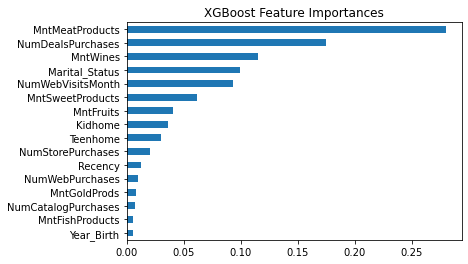

In [164]:
importances = model_boost.feature_importances_
imp = pd.DataFrame(data=importances, index=X_train.columns, columns=['importances'])
imp['importances'].sort_values().plot(kind='barh');
plt.title('XGBoost Feature Importances')
plt.show()

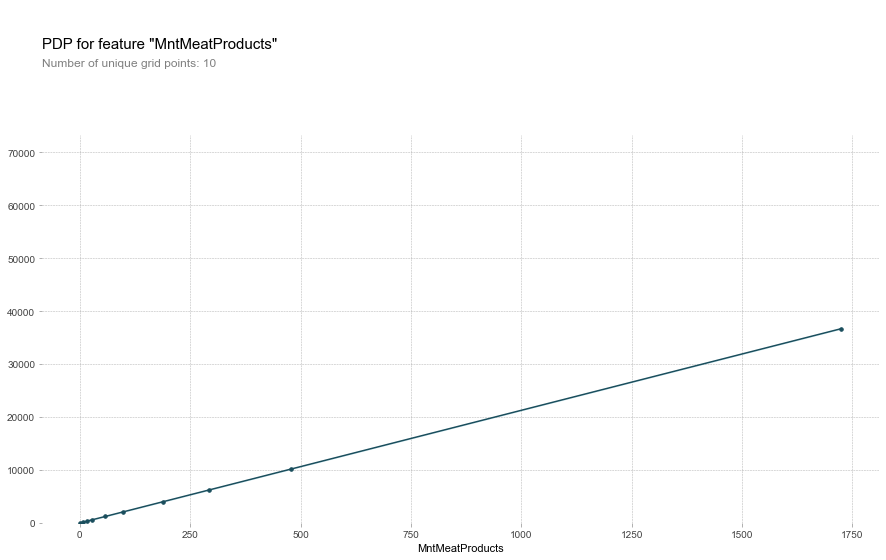

In [177]:
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
feature = 'MntMeatProducts'

isolate = pdp_isolate(
    model_r,
    dataset= X_val, # USE YOUR VALIDATION DATA
    model_features=X_val.columns,
    feature=feature
)
pdp_plot(isolate, feature_name = feature);